# Анализ оттока
    
## Цель: предсказать, уйдет клиент или нет
## Данные
    
|Признак|Описание|
|----|----|
|RowNumber|индекс строки в данных|
|CustomerId|уникальный идентификатор клиента|
|Surname|фамилия|
|CreditScore|кредитный рейтинг|
|Geography|страна проживания|
|Gender|пол|
|Age|возраст|
|Tenure|количество недвижимости у клиента|
|Balance|баланс на счёте|
|NumOfProducts|количество продуктов банка, используемых клиентом|
|HasCrCard|наличие кредитной карты|
|IsActiveMember|активность клиента|
|EstimatedSalary|предполагаемая зарплата|
    
### Этапы исследования

* Загрузите и подготовьте данные. Поясните порядок действий.
* переименовывание колонок]    
* общая информация о датасете
* заполнение пропусков
* Первичный анализ
* исследование целевого признака
* выбор схемы валидации и доли отложенной части
* факторизация строковых признаков
* кодирование 'страна проживания', 'пол', 'возраст', 'количество недвижимости у клиента', 'количество продуктов банка, используемых клиентом', 'наличие кредитной карты', 'активность клиента', 'фамилия'] с помощью OHE/лейблом
* отбор признаков
* варианты кодирования кадегорий с помощью целевой переменной
* оптимизация гиперпараметров
* применение оверсеплинга/даунсемплинга
    
### Выводы:  
    
* в данных присутствуют однофамильцы
* в данных присутствует 3 страны проживания: пользователей из Франции больше, чем пользователей из Германии и Испании в сумме.
* женщин и мужчин примерно одинаковое кол-во
* кредитный рейтинг распределен примерно нормально. хвосты распределения различны (правый тяжелее левого)
* возраст имеет тяжелый правый хвост (малое кол-во возрастных людей). данный признак можно ограничиить справа, тогда модели не будут учитывать аномальные значения, распределение станет близко нормальному
* кол-во недвижимости распределено примерно равномерно от 0 до 10. имеются всплески на 0 и 10.
* баланс на счете имеет тяжелые хвосты, много людей  с нулевым балансом (без выбросов распределение примерно нормальное)
* большинство людей использует 1-2 продукта банка(есть пользователи 3ех и 4ех)
* людей с кредитной картой больше, чем людей без нее в более, чем 2 раза
* активных и неактивных клиентов примерно одинаковое кол-во
* предполагаемая зарплата распределена равномерно от 0 до 2млн
* доля отточных пользователей равна примерно 20% (выборка несбалансирована)
* оптимизация гиперпараметров (Lightgbm - лучшая модель)
    
|модель|кол-во признаков|f1|    
|---|---|---|
|cb     |10|0.59759|   
|lgb    |9|0.59294|   
|xgb    |9|0.58866|   
|rf     |8|0.58371|   
|logit  |133|0.56913|   


|модель |кол-во признаков|roc_auc|  
|---|---|---|
|cb|10| 0.86239|   
|logit|170|0.8556|    
|lgb|10|0.85262|   
|rf|10|0.84812|  
|xgb|8|0.84069|   


|метрика|модель|лучшее значение метрики|лучшие параметры|
|---|---|---|---|
|f1|logit|0.5861|{'C': 43.29, 'penalty': 'l2'}|
|f1|rf| 0.5793|{'max_depth': 13, 'min_samples_split': 3}|
|f1|lgb| 0.599|{'learning_rate': 0.07, 'max_depth': 9, 'min_child_samples': 100, 'num_leaves': 16}|
|f1|cb| 0.5968|{'depth': 4, 'l2_leaf_reg': 9, 'learning_rate': 0.05}|
|roc_auc|logit|0.8577|{'C': 6.14, 'penalty': 'l2'}|
|roc_auc|rf|0.8564|{'max_depth': 9, 'min_samples_split': 50}|
|roc_auc|lgb|0.8641|{'learning_rate': 0.08, 'max_depth': 7, 'min_child_samples': 75, 'num_leaves': 8}|
|roc_auc|cb|0.8598|{'depth': 3, 'l2_leaf_reg': 9, 'learning_rate': 0.05}|



* f1  на отложенной = 0.5889212827988338
* roc_auc на отложенной = 0.8563964580913734  
* f1(oversamopling) = 0.556796402862171, f1(downsamopling) = 0.4351499898797668

### 1. Загрузите и подготовьте данные. Поясните порядок действий.

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')
from collections import defaultdict
from tqdm import tqdm_notebook
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split, KFold,GridSearchCV, StratifiedKFold, cross_validate
from sklearn.metrics import classification_report, roc_auc_score, f1_score
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier,  Pool
import xgboost as xgb
import time
import category_encoders as ce

In [2]:
def _load_data(PATH_TO_FILE):
    ''' Загружает данные '''
    try:
        df = pd.read_csv(PATH_TO_FILE)
        print(df.info())
        return df
    except:
        try:
            df = pd.read_csv('/'+PATH_TO_FILE)
            print(df.info())
            return df
        except:
            raise ValueError('Неправильно задан путь к файлу')

#### 1.1 загружаем данные

In [3]:
# путь к файлу
PATH_TO_FILE = 'datasets/Churn.csv'

# генератор случайных чисел
SEED= 13

In [4]:
df = _load_data(PATH_TO_FILE)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB
None


#### 1.2 переименовываем колонки

In [5]:
column_names_dict = {'RowNumber':'индекс строки в данных',
                     'CustomerId':'уникальный идентификатор клиента',
                     'Surname':'фамилия',
                     'CreditScore':'кредитный рейтинг',
                     'Geography':'страна проживания',
                     'Gender':'пол',
                     'Age':'возраст',
                     'Tenure':'количество недвижимости у клиента',
                     'Balance':'баланс на счёте',
                     'NumOfProducts':'количество продуктов банка, используемых клиентом',
                     'HasCrCard':'наличие кредитной карты',
                     'IsActiveMember':'активность клиента',
                     'EstimatedSalary':'предполагаемая зарплата',
                     'Exited' : 'отток'}

In [6]:
df = df.rename(columns = column_names_dict)

#### 1.3 общая информация о датасете

In [7]:
def _get_data_info(df):    
    ''' Описание данных '''
    L =[]
    for col in df.columns:
        series = df[col]
        nuniques = series.nunique()
        nancount = series.isna().sum()
        dtypes = series.dtypes
        if series.dtypes != object:
            mx = series.max()
            mn = series.min()
        else:
            mx = np.nan
            mn = np.nan
        L.append((col, dtypes, nancount, nuniques, mx, mn))
    report = pd.DataFrame.from_records(L)
    report.columns = ['признак', 'тип', 'число_пропущенных_значений', 'число_уникальных_значений', 'максимум', 'минимум']
    return report.sort_values('число_уникальных_значений').reset_index(drop = True).set_index('признак')

In [8]:
_get_data_info(df)

,тип,число_пропущенных_значений,число_уникальных_значений,максимум,минимум
признак,,,,,
пол,object,0,2,NaN,NaN
наличие кредитной карты,int64,0,2,1.00,0.00
активность клиента,int64,0,2,1.00,0.00
отток,int64,0,2,1.00,0.00
страна проживания,object,0,3,NaN,NaN
"количество продуктов банка, используемых клиентом",int64,0,4,4.00,1.00
количество недвижимости у клиента,float64,909,11,10.00,0.00
возраст,int64,0,70,92.00,18.00
кредитный рейтинг,int64,0,460,850.00,350.00


In [9]:
# пропуски в ко-ве недвижимости заполним 0
df['количество недвижимости у клиента'].fillna(0, inplace = True)

In [10]:
df = df.drop('индекс строки в данных', 1).set_index('уникальный идентификатор клиента')

In [11]:
def _show_eda_plots(df, figsize1, figsize2):
    obj_cols = df.select_dtypes(object).columns
    num_cols = df.drop(obj_cols, 1).columns
    ncols = 3    
    nrows1, nrows2 = int(np.ceil(len(obj_cols) / ncols)), int(np.ceil(len(num_cols) / ncols))    
    
    plt.figure(figsize =figsize1)
    plt.suptitle('строковые признаки', fontsize = 20)    
    for i, col in enumerate(obj_cols):
        plt.subplot(nrows1, ncols, i+1)
        c = df[col].value_counts()
        if len(c)<50:
            surname_counts = c
            sns.barplot(x = surname_counts.values, y = surname_counts.index, orient = 'h', palette = 'Set2')
            plt.title(col)
            plt.xlabel('кол-во')
            plt.ylabel(col)
        else:
            surname_counts = c.value_counts()
            sns.barplot(x = surname_counts.values, y = surname_counts.index, orient = 'h', palette = 'Set2')
            plt.title(col)
            plt.xlabel('кол-во')
            plt.ylabel('встречаемость категорий одного размера')  
    plt.subplots_adjust(hspace = .5, wspace = .5)    

    plt.figure(figsize =figsize2)
    plt.suptitle('числовые признаки', fontsize = 20)
    for i, col in enumerate(num_cols):
        plt.subplot(nrows2, ncols, i+1)
        df[col].hist(edgecolor = 'black', alpha = .7)
        plt.title(col)
        plt.xlabel(col)
        plt.ylabel('кол-во')
    plt.subplots_adjust(hspace = .7, wspace = .9)    

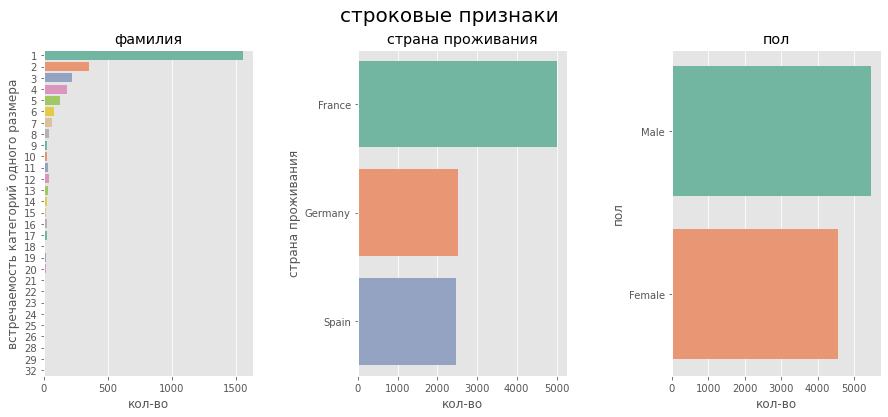

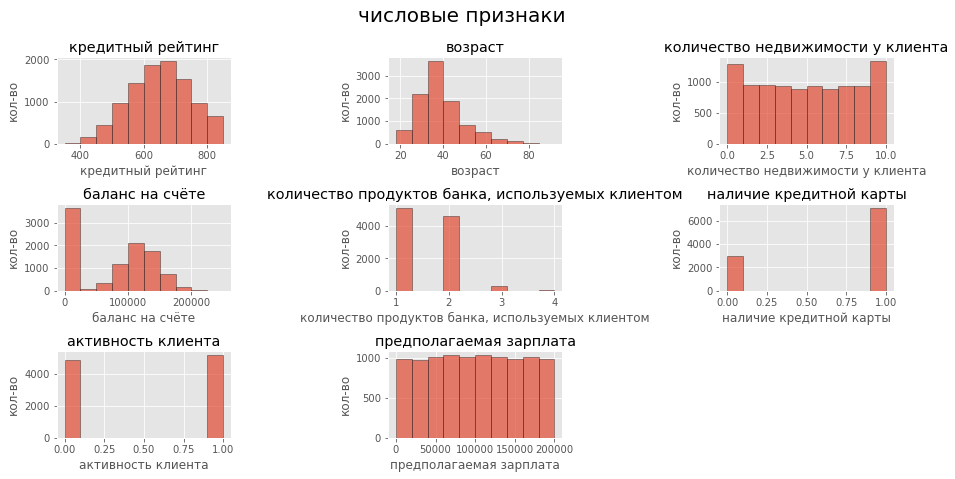

In [12]:
_show_eda_plots(df.drop('отток',1), figsize1 = (15, 6), figsize2 = (15, 7))

* в данных присутствуют однофамильцы
* в данных присутствует 3 страны проживания: пользователей из Франции больше, чем пользователей из Германии и Испании в сумме.
* женщин и мужчин примерно одинаковое кол-во
* кредитный рейтинг распределен примерно нормально. хвосты распределения различны (правый тяжелее левого)
* возраст имеет тяжелый правый хвост (малое кол-во возрастных людей). данный признак можно ограничиить справа, тогда модели не будут учитывать аномальные значения, распределение станет близко нормальному
* кол-во недвижимости распределено примерно равномерно от 0 до 10. имеются всплески на 0 и 10.
* баланс на счете имеет тяжелые хвосты, много людей  с нулевым балансом (без выбросов распределение примерно нормальное)
* большинство людей использует 1-2 продукта банка(есть пользователи 3ех и 4ех)
* людей с кредитной картой больше, чем людей без нее в более, чем 2 раза
* активных и неактивных клиентов примерно одинаковое кол-во
* предполагаемая зарплата распределена равномерно от 0 до 2млн

		Доля отточных клиентов равна 0.2


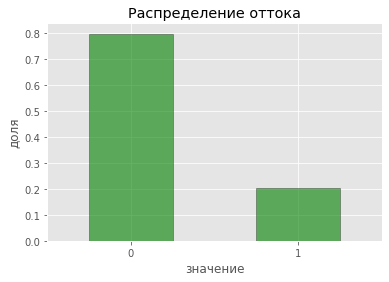

In [13]:
target_barplot = df['отток'].value_counts(normalize = True).plot(kind = 'bar', color = 'green', alpha = .6, edgecolor = 'black')
target_barplot.set_xticklabels(target_barplot.get_xticklabels(), rotation = 0)
print('\t\tДоля отточных клиентов равна {:.1f}'.format(df['отток'].mean()))
plt.title('Распределение оттока')
plt.xlabel('значение')
plt.ylabel('доля')
plt.show()

#### поиск оптимальной схемы валидации

In [14]:
rf_est = RandomForestClassifier(random_state = SEED)
logit_est = LogisticRegression(random_state = SEED)
lgb_est = LGBMClassifier(random_state = SEED)
cb_est = CatBoostClassifier(random_state = SEED, silent = True)
xgb_est = xgb.XGBClassifier(random_state = SEED)

grid = {'estimator' : [(lgb_est, 'lgb'), (logit_est, 'logit')],\
        'test_share' : [.3, .2, .1],\
        'cv' : [(KFold(3, random_state = SEED), 'kf3'), (KFold(5, random_state = SEED), 'kf5'),                
               (StratifiedKFold(3, random_state = SEED), 'skf3'), (StratifiedKFold(5, random_state = SEED), 'skf5')],\
        'scoring' : ['roc_auc', 'f1']}

In [15]:
start = time.time()
L = []
for est, est_name in tqdm_notebook(grid['estimator']):    
    for test_share in tqdm_notebook(grid['test_share']):
        for cv, cv_name in tqdm_notebook(grid['cv']):
            for scoring in grid['scoring']:
                X_TR, X_HOLDOUT, Y_TR, Y_HOLDOUT = train_test_split(df.drop('отток', 1), df['отток'], test_size = test_share,\
                                                                    random_state = SEED, stratify = df['отток'])
                obj_cols = X_TR.select_dtypes(object).columns
                mnmx_scaler = MinMaxScaler()
                X_num_TR = X_TR.drop(obj_cols, 1)
                X_TR.loc[X_num_TR.index, X_num_TR.columns] = mnmx_scaler.fit_transform(X_num_TR)
                X_ohe_TR = pd.get_dummies(X_TR, columns = obj_cols, drop_first = True)
                X_le_TR = X_TR.copy()
                X_le_TR.loc[:, obj_cols] = X_TR[obj_cols].apply(lambda x: pd.factorize(x)[0])
                
                _X_ohe = np.array(X_ohe_TR)
                _X_le = np.array(X_le_TR)
                _y = np.array(Y_TR)
                
                if est_name == 'logit':
                    score = cross_validate(est, _X_ohe, _y, cv = cv, scoring = scoring)['test_score']
                else:
                    score = cross_validate(est, _X_le, _y, cv = cv, scoring = scoring)['test_score']  
                    
                L.append((est_name, test_share, cv_name, scoring, np.mean(score), np.max(score) - np.min(score)))
end = time.time()
print('Выполнено за {} минут'.format((end-start)//60))




Выполнено за 2.0 минут


In [16]:
cv_results = pd.DataFrame.from_records(L)\
               .rename(columns = {0:'модель', 1:'доля_тест_части', 2:'валидация', 3:'метрика', 4:'среднее', 5:'размах'})
optimal_cv, optimal_share = cv_results[cv_results['метрика'] == 'f1'].groupby(['валидация', 'доля_тест_части'])['размах'].mean().idxmin()
print('Лучшая схема валидации = {}, доля тест части  = {}'\
      .format(optimal_cv, optimal_share))

Лучшая схема валидации = kf3, доля тест части  = 0.3


* фиксируем схему валидации, долю отложенной части
* делим данные на трейн и отложенную часть
* масштабируем числовые признаки
* кодируем категории le или ohe

In [17]:
df[['баланс на счёте', 'предполагаемая зарплата']] = df[['баланс на счёте', 'предполагаемая зарплата']].round().apply(np.log1p)

kf3 = KFold(3, random_state = SEED)
test_size = .2
X_TR, X_HOLDOUT, Y_TR, Y_HOLDOUT = train_test_split(df.drop('отток', 1), df['отток'], test_size = test_size,\
                                                    random_state = SEED, stratify = df['отток'])
obj_cols = X_TR.select_dtypes(object).columns
for col in obj_cols:     
    unique_values = X_TR[col].unique()
    d = dict(zip(unique_values, range(len(unique_values))))
    X_TR[col] = X_TR[col].map(d).fillna(-1)  
    X_HOLDOUT[col] = X_HOLDOUT[col].map(d).fillna(-1) 
    
cat_cols = ['страна проживания', 'пол', 'возраст',
            'количество недвижимости у клиента',
            'количество продуктов банка, используемых клиентом',
            'наличие кредитной карты', 'активность клиента', 'фамилия']

X_ohe_TR = pd.get_dummies(X_TR, columns = cat_cols, drop_first = True)

In [20]:
def _select_features(estimator, X, y, cv, scoring):
    
    if isinstance(X, (pd.DataFrame, pd.Series)):
        _X = np.array(X)
    else:
        _X = X
    if isinstance(y, (pd.Series)):    
        _y = np.array(y)
    else:
        _y = y
        
    scores = np.array([])
    print('валидируем признаки ...')
    for i in tqdm_notebook(range(_X.shape[1])):
        _x = _X[:, i].reshape(-1,1)
        scores = np.append(scores,\
                           cross_validate(estimator, _x, _y, cv = cv, scoring = scoring)['test_score'].mean())
    best_score, best_features, drop_features = 0, [], []
    print('добавляем признаки в порядке убывания валидации ...')
    for i in tqdm_notebook(np.argsort(scores)[::-1]):
        current_features = best_features + [i]
        X_CURR = _X[:, current_features]
        score = cross_validate(estimator, X_CURR, _y, cv = cv, scoring = scoring)['test_score'].mean()
        if score > best_score:
            best_score = score
            best_features = current_features  
            best_X = X_CURR
        else:
            drop_features.append(i)
    print('проверяем признаки повторно ...')
    for i in tqdm_notebook(drop_features):
        current_features = best_features + [i]
        X_CURR = _X[:, current_features]
        score = cross_validate(estimator, X_CURR, _y, cv = cv, scoring = scoring)['test_score'].mean()
        if score > best_score:
            best_score = score
            best_features = current_features
            best_X = X_CURR
    return (best_score, best_features, best_X)

In [19]:
D = defaultdict(list)
for metric in ('f1', 'roc_auc'):
    for est, est_name, _X in tqdm_notebook((
                                            (lgb_est, 'lgb', X_TR),\
                                            (rf_est, 'rf', X_TR),\
                                            (logit_est, 'logit', X_ohe_TR),\
                                            (xgb_est, 'xgb', X_TR),\
                                            (cb_est, 'cb', X_TR)
                                           )
                                          ):
        best_score, best_features, X_best_TR = _select_features(est, _X, Y_TR, cv = kf3, scoring = metric)
        D[metric].append((est_name, best_score, best_features, X_best_TR))        

валидируем признаки ...



добавляем признаки в порядке убывания валидации ...



проверяем признаки повторно ...



валидируем признаки ...



добавляем признаки в порядке убывания валидации ...



проверяем признаки повторно ...



валидируем признаки ...



добавляем признаки в порядке убывания валидации ...



проверяем признаки повторно ...



валидируем признаки ...


[07:38:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:38:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:38:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:38:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[07:38:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:38:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:38:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:38:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[07:38:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:38:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:38:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:38:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel


добавляем признаки в порядке убывания валидации ...



проверяем признаки повторно ...


валидируем признаки ...



добавляем признаки в порядке убывания валидации ...



проверяем признаки повторно ...



валидируем признаки ...



добавляем признаки в порядке убывания валидации ...



проверяем признаки повторно ...



валидируем признаки ...



добавляем признаки в порядке убывания валидации ...



проверяем признаки повторно ...



валидируем признаки ...


[08:00:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:00:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:00:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:00:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[08:00:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:00:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:00:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:00:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[08:00:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:00:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:00:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:00:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel


добавляем признаки в порядке убывания валидации ...



проверяем признаки повторно ...


In [70]:
for metric in ('f1', 'roc_auc'):    
    L = [] 
    for el in D[metric]:
        L.append((el[0], el[-1].shape[1], round(el[1], 5)))
    L.sort(key=lambda x: x[2], reverse = True)    
    print('{:^5} | {:^8} | {:^10}'.format('модель', 'кол-во признаков', metric))
    print('---------------------------------------')
    for row in L:
        print('{:<6} | {:<16} | {:<10}'.format(row[0], row[1], row[2]))
    print('---------------------------------------\n')

модель | кол-во признаков |     f1    
---------------------------------------
cb     | 10               | 0.59759   
lgb    | 9                | 0.59294   
xgb    | 9                | 0.58866   
rf     | 8                | 0.58371   
logit  | 133              | 0.56913   
---------------------------------------

модель | кол-во признаков |  roc_auc  
---------------------------------------
cb     | 10               | 0.86239   
logit  | 170              | 0.8556    
lgb    | 10               | 0.85262   
rf     | 10               | 0.84812   
xgb    | 8                | 0.84069   
---------------------------------------



#### пробуем варианты таргет кодирования категориальных признаков

In [72]:
for metric in ('f1', 'roc_auc'):
    print('{:^20} | {:^10} | {}'.format('энкодер', 'число фолдов', metric))
    print('------------------------------------------------')
    for name, encoder in zip(('target ecnoder', 'catboost encoder'), (ce.TargetEncoder(cols = cat_cols, min_samples_leaf = 2),\
                        ce.CatBoostEncoder(cols = cat_cols))):
        for nfolds in [3, 5, 10, 20]:
            enc_df = pd.DataFrame(index = X_TR.index, columns = cat_cols)
            for tr_idx, val_idx in KFold(nfolds).split(X_TR):
                xtr, xval = X_TR.iloc[tr_idx], X_TR.iloc[val_idx]
                ytr, yval = Y_TR.iloc[tr_idx], Y_TR.iloc[val_idx]
                encoder.fit(xtr, ytr)
                enc_df.loc[yval.index, cat_cols] = encoder.transform(xval)
            mean_cv = cross_validate(lgb_est, np.column_stack([X_TR.drop(columns = enc_df.columns), enc_df]),\
                               Y_TR.values, cv = kf3, scoring = metric)['test_score'].mean()

            print('{:^20} | {:^12} | {}'.format(name, nfolds, round(mean_cv, 5)))
    print('------------------------------------------------\n')

      энкодер        | число фолдов | f1
------------------------------------------------
   target ecnoder    |      3       | 0.57301
   target ecnoder    |      5       | 0.57603
   target ecnoder    |      10      | 0.58356
   target ecnoder    |      20      | 0.58581
  catboost encoder   |      3       | 0.56618
  catboost encoder   |      5       | 0.57784
  catboost encoder   |      10      | 0.57049
  catboost encoder   |      20      | 0.58546
------------------------------------------------

      энкодер        | число фолдов | roc_auc
------------------------------------------------
   target ecnoder    |      3       | 0.84941
   target ecnoder    |      5       | 0.84794
   target ecnoder    |      10      | 0.85142
   target ecnoder    |      20      | 0.86456
  catboost encoder   |      3       | 0.85127
  catboost encoder   |      5       | 0.84834
  catboost encoder   |      10      | 0.85385
  catboost encoder   |      20      | 0.86134
-----------------------------

#### оптимизируем гиперпараметры моделей

In [158]:
D_parameters = defaultdict(list)

In [161]:
HYPERPARAMETERS_TO_TUNE_d = {'logit' : [LogisticRegression(random_state = SEED), {'C' : np.around(np.logspace (-2, 4, 100), 2), 'penalty' : ['l1', 'l2']}],
                             'rf' : [RandomForestClassifier(random_state = SEED), {'max_depth': [3, 5, 7, 9, 11, 13],\
                                     'min_samples_split' : [3, 10, 20, 50]}],\
                             'lgb' :  [LGBMClassifier(random_state = SEED), {'min_child_samples' : [75, 100],'max_depth':[5, 7, 9],\
                                                                             'num_leaves' : [8, 16, 24], \
                                                                             'learning_rate' : np.around(np.linspace(.05, .2, 10), 2)}],                             
                             'cb' : [CatBoostClassifier(random_state = SEED, silent = True),{'depth': [3, 4, 5],
                                     'learning_rate' : [.05, 0.1],
                                     'l2_leaf_reg': [4,9,11]}]}


In [163]:
%%time
print('{:<5} | {:<5} | {:<5} | {:<5}'.format('метрика', 'модель', 'лучшее значение метрики', 'лучшие параметры'))
print('-------------------------------------------------------------------------------------------------------')
grid_results = []
for metric in ['f1', 'roc_auc']:    
    for k, v in HYPERPARAMETERS_TO_TUNE_d.items():
        idx = np.argwhere(np.array([el[0] for el in D[metric]]) == k).flatten()[0]
        _X_TR = D[metric][idx][-1]        
        grid = GridSearchCV(v[0], param_grid = v[1], cv = kf3, scoring = metric)
        grid.fit(_X_TR, Y_TR.values)
        grid_results.append((metric, k, grid.best_score_, grid.best_params_))        
        print('{:<7} | {:<6} | {:<23} | {:<20}'.format(metric, k, round(grid.best_score_,4), str(grid.best_params_)))
    print('-------------------------------------------------------------------------------------------------------\n')        

метрика | модель | лучшее значение метрики | лучшие параметры
-------------------------------------------------------------------------------------------------------
f1      | logit  | 0.5861                  | {'C': 43.29, 'penalty': 'l2'}
f1      | rf     | 0.5793                  | {'max_depth': 13, 'min_samples_split': 3}
f1      | lgb    | 0.599                   | {'learning_rate': 0.07, 'max_depth': 9, 'min_child_samples': 100, 'num_leaves': 16}
f1      | cb     | 0.5968                  | {'depth': 4, 'l2_leaf_reg': 9, 'learning_rate': 0.05}
-------------------------------------------------------------------------------------------------------

roc_auc | logit  | 0.8577                  | {'C': 6.14, 'penalty': 'l2'}
roc_auc | rf     | 0.8564                  | {'max_depth': 9, 'min_samples_split': 50}
roc_auc | lgb    | 0.8641                  | {'learning_rate': 0.08, 'max_depth': 7, 'min_child_samples': 75, 'num_leaves': 8}
roc_auc | cb     | 0.8598                  | {'dept

#### модели, оптимальные параметры

In [176]:
X_lgb_est_TR

,возраст,"количество продуктов банка, используемых клиентом",активность клиента,количество недвижимости у клиента,пол,страна проживания,фамилия,баланс на счёте,предполагаемая зарплата
уникальный идентификатор клиента,,,,,,,,,
15758856,45,2,0,7.0,0,0,0,0.000000,12.030272
15644934,26,1,0,9.0,0,0,1,11.566684,9.291275
15627232,44,1,1,7.0,0,1,2,11.645742,11.262295
15775709,27,1,0,10.0,1,0,3,11.498735,10.338964
15726634,47,1,0,1.0,0,0,4,0.000000,11.464491
...,...,...,...,...,...,...,...,...,...
15659677,47,1,1,8.0,0,0,1088,11.866276,11.036308
15607577,27,1,1,8.0,0,2,1428,0.000000,12.144245
15672016,35,2,1,1.0,0,0,674,0.000000,8.127405


In [185]:
for metric in ('f1', 'roc_auc'):
    to_argm = []
    for l in grid_results:
        if (l[0]==metric) & (l[1] == 'lgb'):        
            lgb_best = LGBMClassifier(random_state = SEED, **l[-1])    
    X_lgb_est_TR = X_TR.iloc[:, D[metric][0][2]]
    X_lgb_est_HOLDOUT = X_HOLDOUT.iloc[:, D[metric][0][2]]
    lgb_best.fit(X_lgb_est_TR.fillna(0).values, Y_TR.values)
    if metric == 'f1':
        print('{}  на отложенной = {}'.format(metric,\
                                             f1_score(Y_HOLDOUT.values, lgb_best.predict(X_lgb_est_HOLDOUT.values))))        
    else:
        print('{} на отложенной = {}'.format(metric,\
                                              roc_auc_score(Y_HOLDOUT.values, lgb_best.predict_proba(X_lgb_est_HOLDOUT.values)[:, 1])))

f1  на отложенной = 0.5889212827988338
roc_auc на отложенной = 0.8563964580913734


#### oversampling, downsampling

In [188]:
idx0 = Y_TR[Y_TR == 0].index
idx1 = Y_TR[Y_TR == 1].index
over_f1, down_f1 = [], []
n_iter = 10

for SEED in tqdm_notebook(range(n_iter)):
    np.random.seed(SEED)
    oversampling = np.random.choice(idx1, len(idx0), replace = True)
    downsampling = np.random.choice(idx0, len(idx1), replace = False)

    over_X_tr = X_cb_TR.loc[oversampling.tolist() + idx0.tolist()]
    over_y_tr = Y_TR.loc[oversampling.tolist() + idx0.tolist()]

    down_X_tr = X_cb_TR.loc[downsampling.tolist() + idx1.tolist()]
    down_y_tr = Y_TR.loc[downsampling.tolist() + idx1.tolist()]
    
    over_score = cross_validate(lgb_est, over_X_tr.values, over_y_tr.values,\
                   cv = kf3, scoring = scoring)['test_score'].mean()
    down_score = cross_validate(lgb_est, down_X_tr.values, down_y_tr.values,\
                   cv = kf3, scoring = scoring)['test_score'].mean()
    over_f1.append(over_score)
    down_f1.append(down_score)    

In [193]:
print('f1(oversamopling) = {}'.format(np.mean(over_f1)))
print('f1(downsamopling) = {}'.format(np.mean(down_f1)))

f1(oversamopling) = 0.556796402862171
f1(downsamopling) = 0.4351499898797668
